# Scene recognition

In [70]:
import torch,json,os,importlib

# Select model from available
os.listdir("pretrained_models/")
model_path="pretrained_models/sub2/"
os.listdir(model_path)

# Load model
with open(model_path+'model_config.json',"r")as f:
    model_config=json.load(f)


module = importlib.import_module('models.{}'.format(model_config['arch']))
Network = getattr(module, 'Network')
model=Network(model_config)


# Load pretrained weights
state_dict=torch.load(model_path+"/model_state_dict.pth")
# print(state_dict)


# if the weights are float16 cast the model
if [v for k,v in state_dict.items()][0].dtype==torch.float16:
    model=model.half()
    print("model in float16")
model.load_state_dict(state_dict)

# dir(model)

n_blocks_per_stage is specified ignoring the depth param, nc=None



Warning Pruning only 1x1 CONVS

12 0.05892556509887896 0.23570226039551584
13 0.05892556509887896 0.23570226039551584
14 0.05892556509887896 0.23570226039551584
15 0.1767766952966369 0.23570226039551584
16 0.125 0.23570226039551584
17 0.125 0.23570226039551584
model in float16


<All keys matched successfully>

# Evaluate on dataset

In [2]:
import datasets
# the eval json config dataset specifies that the norms should be calculated from all the training clips. 
with open('configs/datasets/dcase2020b_eval.json',"r")as f:
    dataset_config=json.load(f)

# print(dataset_config)

datasetm=datasets.DatasetsManager(dataset_config['audiodataset'])

trainds=datasetm.get_train_set()
testds=datasetm.get_train_set()
evalds=datasetm.get_sub_dataset()

# dir(datasetm)


loading dataset from 'd20t1b'
normalizing dataset
normalized train!
attempting to load x from cache at datasets/cached_datasets/d20t1b/tr_mean_676d70_f1_apd18_stereo_obj.pt...
loaded datasets/cached_datasets/d20t1b/tr_mean_676d70_f1_apd18_stereo_obj.pt from cache in 0.0003466606140136719 
attempting to load x from cache at datasets/cached_datasets/d20t1b/tr_std_676d70_f1_apd18_stereo_obj.pt...
loaded datasets/cached_datasets/d20t1b/tr_std_676d70_f1_apd18_stereo_obj.pt from cache in 0.00015091896057128906 
mean and std
tensor([[[-6.1635],
         [-3.9325],
         [-2.9757],
         [-2.5591],
         [-2.7313],
         [-2.3524],
         [-2.2837],
         [-2.2328],
         [-2.2637],
         [-2.4604],
         [-2.1427],
         [-2.1340],
         [-2.1269],
         [-2.1630],
         [-2.3167],
         [-2.0535],
         [-2.0338],
         [-2.0095],
         [-2.0652],
         [-2.2139],
         [-1.9962],
         [-1.9848],
         [-1.9695],
         [-2.064

In [3]:
all_y=0
corr_y=0
model.eval()
model.cuda()
half_mode=True
data_loader = torch.utils.data.DataLoader(trainds,
                                          batch_size=1,
                                          shuffle=False)
with torch.no_grad():
    for i,(x,idx,y) in enumerate(data_loader):
        if i%10==0:
            print(i,"/",len(data_loader),end="\r")
        x=x.cuda()
        if half_mode:
            x=x.half()
        out=model(x)
        all_y+=1
        corr_y+=(torch.argmax(out).cpu()==y).sum().item()
print("all ", all_y," correct ",corr_y," ratio=",corr_y*1./all_y) 
    

x: torch.Size([1, 2, 256, 431])
in_c: torch.Size([1, 64, 127, 215])
stage1: torch.Size([1, 64, 15, 26])
stage2: torch.Size([1, 128, 15, 26])
stage3: torch.Size([1, 128, 15, 26])
feed_forward: torch.Size([1, 3, 1, 1])
logit: torch.Size([1, 3])


KeyboardInterrupt: 

# Get format of input!

In [71]:
import librosa
import numpy as np
def processor_d18_stereo(file_path):
    n_fft = 2048  # 2048
    sr = 22050  # 22050  # 44100  # 32000
    mono = False  #=
    log_spec = False
    n_mels = 256

    hop_length = 512
    fmax = None

    if mono:
        # this is the slowest part resampling
        sig, sr = librosa.load(file_path, sr=sr, mono=True)
        sig = sig[np.newaxis]
    else:
        sig, sr = librosa.load(file_path, sr=sr, mono=False)
        dpath, filename = os.path.split(file_path)

    print(sig.shape)


    spectrograms = []
    for y in sig:

        # compute stft
        stft = librosa.stft(np.asfortranarray(y), n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann', center=True,
                            pad_mode='reflect')

        # keep only amplitures
        stft = np.abs(stft)

        # spectrogram weighting
        if log_spec:
            stft = np.log10(stft + 1)
        else:
            freqs = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)
            stft = librosa.perceptual_weighting(stft ** 2, freqs, ref=1.0, amin=1e-10, top_db=80.0)

        # apply mel filterbank
        spectrogram = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels, fmax=fmax)

        # keep spectrogram
        spectrograms.append(np.asarray(spectrogram))

    spectrograms = np.asarray(spectrograms, dtype=np.float32)

    return spectrograms


def processor_d18_stereo_tensor(tensor):
    n_fft = 2048  # 2048
    sr = 22050  # 22050  # 44100  # 32000
    mono = False  #=
    log_spec = False
    n_mels = 256

    hop_length = 512
    fmax = None

    spectrograms = []
    for y in tensor:

        y = y.to('cpu').numpy()

        # compute stft
        stft = librosa.stft(np.asfortranarray(y), n_fft=n_fft, hop_length=hop_length, win_length=None, window='hann', center=True,
                            pad_mode='reflect')

        # keep only amplitures
        stft = np.abs(stft)

        # spectrogram weighting
        if log_spec:
            stft = np.log10(stft + 1)
        else:
            freqs = librosa.core.fft_frequencies(sr=sr, n_fft=n_fft)
            stft = librosa.perceptual_weighting(stft ** 2, freqs, ref=1.0, amin=1e-10, top_db=80.0)

        # apply mel filterbank
        spectrogram = librosa.feature.melspectrogram(S=stft, sr=sr, n_mels=n_mels, fmax=fmax)

        # keep spectrogram
        spectrograms.append(np.asarray(spectrogram))

    spectrograms = np.asarray(spectrograms, dtype=np.float32)

    return spectrograms

In [67]:
tr_mean = torch.load('datasets/cached_datasets/d20t1b/tr_mean_676d70_f1_apd18_stereo_obj.pt')
tr_std = torch.load('datasets/cached_datasets/d20t1b/tr_std_676d70_f1_apd18_stereo_obj.pt')

tr_mean = tr_mean.to('cuda')
tr_std = tr_std.to('cuda')

tr_mean.half()
tr_std.half()

tensor([[[1.0889],
         [1.0234],
         [0.9541],
         [0.9600],
         [1.0840],
         [0.9683],
         [0.9346],
         [0.9028],
         [0.9170],
         [1.0234],
         [0.9136],
         [0.9038],
         [0.9048],
         [0.9277],
         [0.9971],
         [0.8911],
         [0.8867],
         [0.8892],
         [0.9258],
         [0.9937],
         [0.9004],
         [0.8906],
         [0.8926],
         [0.9404],
         [0.9980],
         [0.9116],
         [0.9072],
         [0.9077],
         [0.9565],
         [0.9956],
         [0.9136],
         [0.9102],
         [0.9102],
         [0.9702],
         [0.9854],
         [0.9082],
         [0.9023],
         [0.9048],
         [0.9736],
         [0.9795],
         [0.9116],
         [0.9043],
         [0.9038],
         [0.9795],
         [0.9702],
         [0.9106],
         [0.9023],
         [0.9023],
         [0.9844],
         [0.9536],
         [0.9023],
         [0.8975],
         [0.

In [58]:
import pandas as pd

model.cuda()
model.eval()
model.to('cuda')

# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/tram-vienna-285-8638-a.wav' # returns 1
# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/street_pedestrian-lyon-1162-44093-a.wav' # returns 1
# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/metro-prague-1163-44094-a.wav' # returns 1
# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/airport-lisbon-1000-40000-a.wav' 
# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/bus-lyon-1001-40001-a.wav' 
# sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/audio/street_pedestrian-lyon-1003-44093-a.wav' # returns 1


results_dict = {}
results_dict['indoor'] = {}
results_dict['indoor'][0] = 0
results_dict['indoor'][1] = 0
results_dict['indoor'][2] = 0
results_dict['outdoor'] = {}
results_dict['outdoor'][0] = 0
results_dict['outdoor'][1] = 0
results_dict['outdoor'][2] = 0
results_dict['transportation'] = {}
results_dict['transportation'][0] = 0
results_dict['transportation'][1] = 0
results_dict['transportation'][2] = 0


# Load all sample files and evaluate
metadata = pd.read_csv('datasets/TAU-urban-acoustic-scenes-2020-3class-development/meta.csv',sep='\t')

for idx, row in metadata.iterrows():
    if idx%10==0:
        print("%s / %s" % (idx, len(metadata)))
    
    sample_file = 'datasets/TAU-urban-acoustic-scenes-2020-3class-development/' + row['filename']
    label = row['scene_label']

    # Compute estimate
    x = processor_d18_stereo(sample_file)

    print(x.shape)
    x = torch.from_numpy(x).to('cuda')
    x = x.half()

    x.unsqueeze_(0)

    # print(x.shape)
    x = (x - tr_mean) / tr_std
    x = x.half()

    out=model(x)
# print(out)
    # print(torch.argmax(out))
    results_dict[label][torch.argmax(out).item()] +=1

print(results_dict)


0 / 14400
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)


/home/jd/anaconda3/envs/gracias/lib/python3.10/site-packages/librosa/core/convert.py:1870: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
10 / 14400
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
20 / 14400
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
30 / 14400
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 256, 431)
(2, 220500)
(2, 2

KeyboardInterrupt: 

# Classify recorded scene

In [72]:
tr_mean = torch.load('datasets/cached_datasets/d20t1b/tr_mean_676d70_f1_apd18_stereo_obj.pt')
tr_std = torch.load('datasets/cached_datasets/d20t1b/tr_std_676d70_f1_apd18_stereo_obj.pt')

tr_mean = tr_mean.to('cuda')
tr_std = tr_std.to('cuda')

tr_mean.half()
tr_std.half()

print(tr_mean.size())
print(tr_std.size())

torch.Size([1, 256, 1])
torch.Size([1, 256, 1])


In [85]:
import torchaudio.transforms as T
from IPython.display import Audio

sample_rate = 48000
resample_rate = 22050
datatype = torch.float16
resampler = T.Resample(sample_rate, resample_rate, dtype=datatype)

resampler = resampler.to('cuda')

model.cuda()
model.eval()
model = model.to('cuda')


signals = torch.load('../../frame_data_recovered.pt')
print(signals.shape)
print(signals.dtype)

scene_indices = [0,1]

scene_frames = signals[:,scene_indices]
scene_frames = scene_frames.to('cuda')
print(scene_frames.shape)

# print(signals)
# print(scene_frames)



# Downsample from 48k -> 22.05k
resampled_signal = resampler(scene_frames.T)
print(resampled_signal.shape)


# PLOT - sanity check
plot_signal = resampled_signal.cpu()

# Preprocess
preproc_sig = processor_d18_stereo_tensor(resampled_signal)
print(preproc_sig.shape)

# classify
x = torch.from_numpy(preproc_sig).to('cuda')
x = x.half()

x.unsqueeze_(0)

# print(x.shape)
x = (x - tr_mean) / tr_std
x = x.half()

out=model(x)
print(out)

torch.Size([480000, 7])
torch.float16
torch.Size([480000, 2])
torch.Size([2, 220500])
(2, 256, 431)
tensor([[-3.3809,  3.0820, -0.6978]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SqueezeBackward1>)


In [86]:
Audio(data=plot_signal,rate=resample_rate)

# PyRoomAudio dev

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import torch
from pyroomacoustics.doa import circ_dist
import IPython

In [35]:
# Create the array
R = pra.linear_2D_array([2, 1.5], 4, 0, 0.1)
print(R)

kinect_R = np.array([[0.0, 0.04, 0.02, -0.02, -0.04, -0.02, 0.02],
            [0.0, 0.0, -0.03464, -0.03464, 0.0, 0.03464, 0.03464]])
kinect_R [0,:] +=25.0
kinect_R [1,:] +=20.0
print(kinect_R)

philbart_R = np.array([[0.0, 0.0, 0.0, -0.5, -0.5, -0.5, 0.5, 0.5, 0.5],
            [-0.5, 0.0, 0.5, -0.5, 0.0, 0.5, -0.5, 0.0, 0.5]])
philbart_R [0,:] +=25.0
philbart_R [1,:] +=20.0
print(philbart_R)

[[1.85 1.95 2.05 2.15]
 [1.5  1.5  1.5  1.5 ]]
[[25.      25.04    25.02    24.98    24.96    24.98    25.02   ]
 [20.      20.      19.96536 19.96536 20.      20.03464 20.03464]]
[[25.  25.  25.  24.5 24.5 24.5 25.5 25.5 25.5]
 [19.5 20.  20.5 19.5 20.  20.5 19.5 20.  20.5]]


## Beamforming calcs

<Figure size 640x480 with 0 Axes>

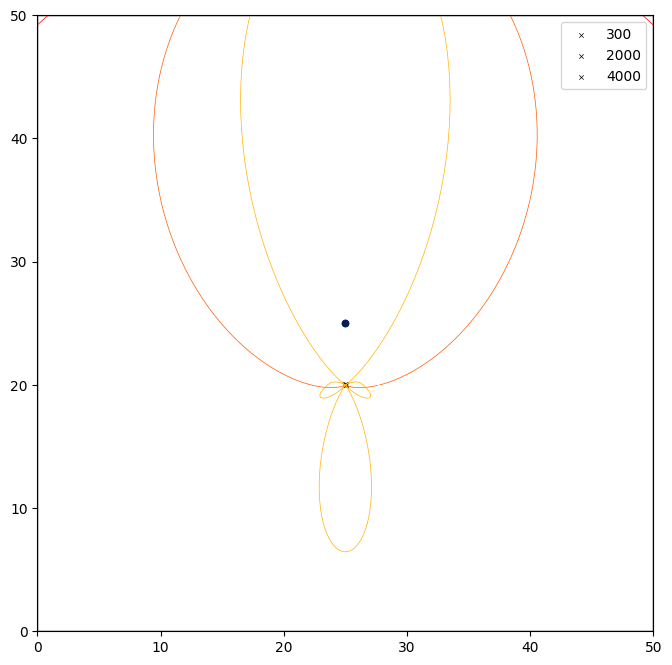

<Figure size 640x480 with 0 Axes>

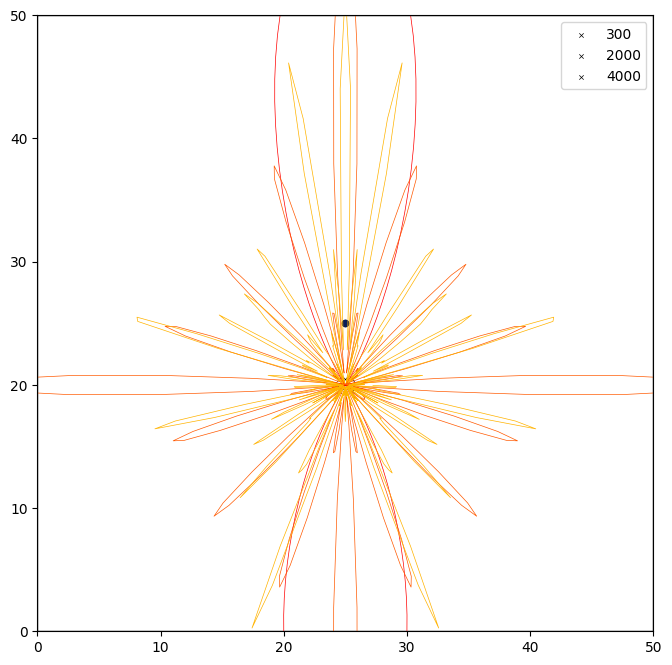

In [39]:
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples
fs=48000
c=343.0
nfft=256

# Create "Room"
kinect_room_bf = pra.ShoeBox([50,50], fs=fs, max_order=12)
philbart_room_bf = pra.ShoeBox([50,50], fs=fs, max_order=12)
source = np.array([25, 25])
kinect_room_bf.add_source(source, delay=0.)
philbart_room_bf.add_source(source, delay=0.)

# Create kinect and philbart mic arrays
kinect_mics = pra.Beamformer(kinect_R, room_bf.fs, N=nfft, Lg=Lg)
philbart_mics = pra.Beamformer(philbart_R, room_bf.fs, N=nfft, Lg=Lg)
kinect_room_bf.add_microphone_array(kinect_mics)
philbart_room_bf.add_microphone_array(philbart_mics)

# Compute beamformer weights
kinect_mics.rake_delay_and_sum_weights(kinect_room_bf.sources[0][:1])
philbart_mics.rake_delay_and_sum_weights(philbart_room_bf.sources[0][:1])

plt.figure()
fig, ax = kinect_room_bf.plot(freq=[300, 2000, 4000], img_order=0)
ax.legend(['300', '2000','4000'])
fig.set_size_inches(20, 8)

plt.figure()
fig, ax = philbart_room_bf.plot(freq=[300, 2000,4000], img_order=0)
ax.legend(['300', '2000','4000'])
fig.set_size_inches(20, 8)



In [ ]:


# Analyze Kinect beam pattern




In [7]:
# Load signal data from mike array
signals = torch.load('../../frame_data_recovered.pt')
print(signals.T.shape)

# compute STFT
nfft=256
fs=48000
c=343.0
freq_bins = np.arange(15, 300)  # FFT bins to use for estimation
Lg_t = 0.100                # filter size in seconds
Lg = np.ceil(Lg_t*fs)       # in samples


mics = pra.Beamformer(kinect_R, fs, N=nfft, Lg=Lg)

torch.Size([6, 16000])


In [8]:
sources = {'twelve_o_clock': {'az': 0.},
# 'eleven_o_clock': {'az': 30.},
# 'ten_o_clock': {'az': 60.},
'nine_o_clock': {'az': 90.},
# 'eight_o_clock': {'az': 120.},
# 'seven_o_clock': {'az': 150.},
'six_o_clock': {'az': 180.},
# 'five_o_clock': {'az': 210.},
# 'four_o_clock': {'az': 240.},
'three_o_clock': {'az': 270.}} #,
# 'two_o_clock': {'az': 300.},
# 'one_o_clock': {'az': 330.}}

mics.record(signals.T,fs)

for src in sources.keys():
    exec(src+ "_bf = mics")
    exec(src+ "_bf.far_field_weights(" + str(sources[src]['az']) + "*np.pi/180)")

# laptop_src = pra.soundsource.SoundSource(position=[-.5,-1])
# front_src = pra.soundsource.SoundSource(position=[.1,0])
plt.figure()
for bf in sources.keys():
    bf += "_bf"
    print("plt.plot(" + bf + ".process()")
    exec("plt.plot(" + bf + ".process())")
    


# mics.far_field_weights(240*np.pi/180)
# mics.rake_delay_and_sum_weights(laptop_src)



# proc = mics.process()
# mics.plot()

# # IPython.display.Audio(data=signals.T[0,:],rate=fs)
# IPython.display.Audio(data=proc, rate=fs)

NameError: The signals array should have as many lines as there are microphones.

In [9]:
proc.shape

NameError: name 'proc' is not defined

## DOA calcs

In [100]:
# Load signal data from mike array
signals = torch.load('../../frame_data_recovered.pt')
print(signals.T.shape)

# compute STFT
nfft=256
fs=48000
c=343.0
freq_bins = np.arange(15, 300)  # FFT bins to use for estimation
X = np.array(
    [
        pra.transform.stft.analysis(signal, nfft, nfft // 2).T
        for signal in signals.T
    ]
)
print(X.shape)

torch.Size([7, 48000])
(7, 129, 375)


FRIDA


/home/jd/anaconda3/envs/gracias/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


FRIDA
  Recovered azimuth: [351.72459364] degrees
  Error: [21.72459364] degrees


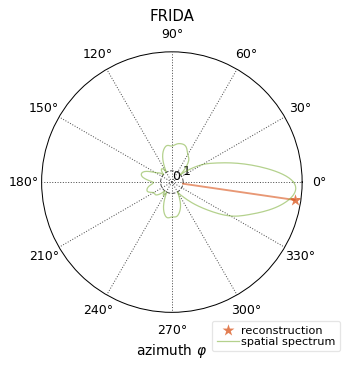

In [107]:
##############################################
# Now we can test all the algorithms available
algo_names = sorted(pra.doa.algorithms.keys())
algo_names = ['FRIDA']
azimuth=330*np.pi/180

for algo_name in algo_names:
    print(algo_name)
    # Construct the new DOA object
    # the max_four parameter is necessary for FRIDA only
    doa = pra.doa.algorithms[algo_name](kinect_R, fs, nfft, c=c, max_four=4)

    # this call here perform localization on the frames in X
    doa.locate_sources(X, freq_bins=freq_bins)

    doa.polar_plt_dirac()
    plt.title(algo_name)

    # doa.azimuth_recon contains the reconstructed location of the source
    print(algo_name)
    print("  Recovered azimuth:", doa.azimuth_recon / np.pi * 180.0, "degrees")
    print("  Error:", circ_dist(azimuth, doa.azimuth_recon) / np.pi * 180.0, "degrees")

plt.show()

# Grid/heatmap

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

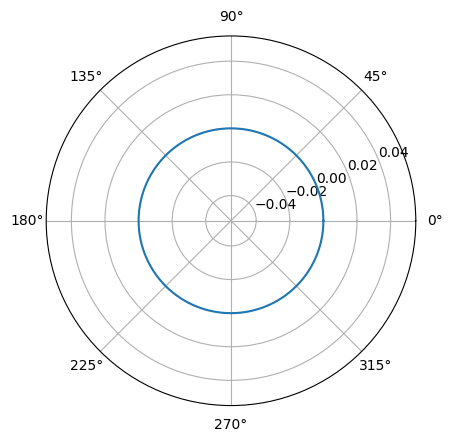

In [111]:

# doa.grid.set_values(0.0)
doa._process(X)
doa.grid.plot()

print(doa.grid.values)

# Torch audio dev

In [6]:
import torch
import torchaudio
import numpy as np

In [7]:
n_channels = 7
src = 'plughw:2,0'
sample_rate = 48000
hop_size = 4800
frame_size = 4800
fmt = 'alsa'
options = {"sample_rate": str(sample_rate), "channels": str(n_channels)}

streamer = torchaudio.io.StreamReader(src=src, format=fmt, option={'sample_rate':'48000','channels':'7'})
streamer.add_basic_audio_stream(frames_per_chunk=hop_size, sample_rate=sample_rate, num_channels=n_channels)

print(str(streamer.get_src_stream_info(0)))

SourceAudioStream(media_type='audio', codec='pcm_s16le', codec_long_name='PCM signed 16-bit little-endian', format='s16', bit_rate=5376000, num_frames=0, bits_per_sample=0, metadata={}, sample_rate=48000.0, num_channels=7)


In [8]:
def beam_projection(pos, az):
    pos_angle = np.arctan2(pos[1],pos[0])
    # make sure pos_angle in range [0, 2pi)

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi

    while pos_angle < 0:
        pos_angle += 2*np.pi
    while pos_angle > 2*np.pi:
        pos_angle -= 2*np.pi
    
    print("mike_angle: %s" % pos_angle)
    print("az: %s" % az)
    delta_angle = az - pos_angle
    print("delta: %s" % delta_angle)
    return np.sqrt(pos[0]**2 + pos[1]**2)*np.cos(delta_angle)

In [9]:
pos = [np.sqrt(3),1]
az = np.deg2rad(30)

beam_projection(pos,az)

mike_angle: 0.5235987755982989
az: 0.5235987755982988
delta: -1.1102230246251565e-16


1.9999999999999998

# Examine beams

In [10]:
import torch
import matplotlib.pyplot as plt

orig_channels = torch.load('../../frame_data_original.pt')
rec_channels = torch.load('../../frame_data_recovered.pt')
beams = torch.load('../../beam_data.pt')

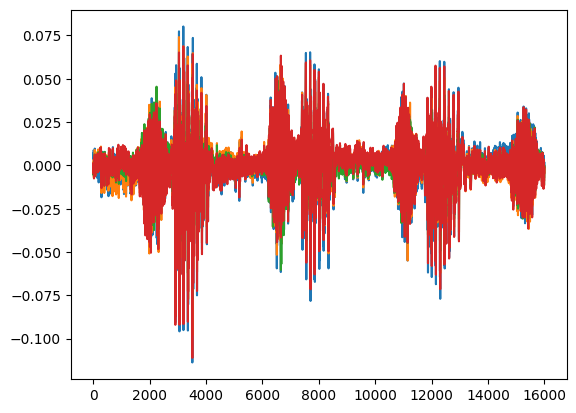

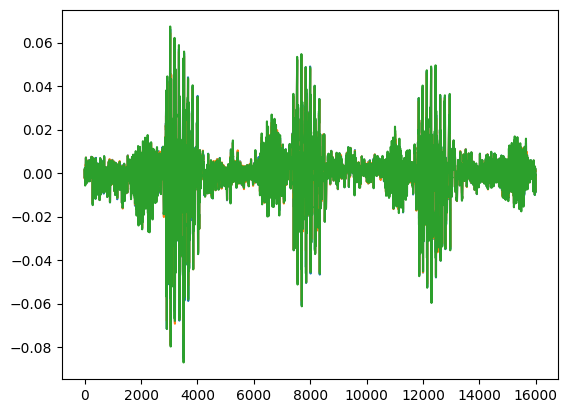

In [13]:
# plt.plot(beam[:,2])
plt.figure(1)
for channel in [1,2,3,4]:
    # print(channel)
    plt.plot(rec_channels[:,channel])
# plt.plot(rec_channels[:,0])

plt.figure(2)
for beam in range(beams.shape[1]):
    plt.plot(beams[:,beam])

In [25]:
# parameter i/o
import json


param_dict = {0: {'pos': [0., 0., 0.]},
                             1: {'pos': [.04, 0., 0.]},
                             2: {'pos': [.02, -.034641016, 0.]}, 
                             3: {'pos': [-.02, -.034641016, 0.]},
                             4: {'pos': [-.04, 0., 0.]},
                             5: {'pos': [-.02, .034641016, 0.]}, 
                             6: {'pos': [.02, .034641016, 0.]}}

In [26]:

json.dump(param_dict, 'params.json')

AttributeError: 'str' object has no attribute 'write'